In [1]:
# -*- coding: utf-8 -*-
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import json
from glob import glob
import cv2
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from models import Densenet
from efficientnet_pytorch import EfficientNet


In [2]:
seed = 5487
device = 'cuda:0'
if not torch.cuda.is_available(): device='cpu'
load_model_path = './{17}_loss{1.6857}.pth'
torch.manual_seed(seed)
np.random.seed(seed)

with open('./word2label.json', 'r', encoding='utf-8') as f:
    word2label = json.load(f)
label2word = {val:key for key, val in word2label.items()}

label2word2 = dict()
with open('./idx2class.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for idx, l in enumerate(lines):
        label2word2[idx] = l.strip()

first_model = '{2}_loss.pth'
second_model = 'gridmask.pt'
third_model = 'efficientnet_b3.pt'
forth_model = 'affine.pt'

model1 = Densenet(len(word2label)).to(device)
model1.load_state_dict(torch.load(first_model, map_location=torch.device('cpu')))
model1.eval()       

model2 = EfficientNet.from_name('efficientnet-b3')
model2._fc = nn.Linear(1536, 800)
model2.load_state_dict(torch.load(second_model, map_location=torch.device('cpu')))
model2.eval()

model3 = EfficientNet.from_name('efficientnet-b3')
model3._fc = nn.Linear(1536, 800)
model3.load_state_dict(torch.load(third_model, map_location=torch.device('cpu')))
model3.eval()

model4 = EfficientNet.from_name('efficientnet-b3')
model4._fc = nn.Linear(1536, 800)
model4.load_state_dict(torch.load(forth_model, map_location=torch.device('cpu')))
model4.eval()

softmax = nn.Softmax(dim=1)

In [3]:
def preprocess_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thre_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    thre_img = cv2.fastNlMeansDenoising(thre_img, h=13, searchWindowSize=7)
    
    thre_img = cv2.fastNlMeansDenoising(thre_img, h=13, searchWindowSize=7)
    kernel = np.ones((3,3), np.uint8)
    thre_img = cv2.erode(thre_img, kernel, iterations = 1)

    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
    dilate = cv2.dilate(thre_img, rect_kernel, iterations = 1)
    
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0: bound = cv2.resize(img, (50,50))
    else:
        max_area = -1
        bx, by, bw, bh = None, None, None, None
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w * h > max_area:
                bx, by, bw, bh = x, y, w, h
                max_area = w * h

        bound = cv2.resize(img[by:by+bh, bx:bx+bw], (50, 50))
    
    _, bound = cv2.threshold(bound, 0, 255, cv2.THRESH_OTSU)
    bound = cv2.cvtColor(bound, cv2.COLOR_GRAY2BGR)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    bound = transform(bound)
    return bound

def preprocess3_img(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img

Loading image  1621936977_img.jpg


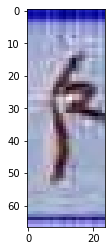

Resnet ('仁', 0.6584904789924622)   gridmask ('婉', 0.13531941175460815)   efficientnet ('膠', 0.1749010533094406)  affine ('綸', 0.2203705757856369)  Ensemble ('仁', 0.16489463213474664)
Loading image  1621936981_img.jpg


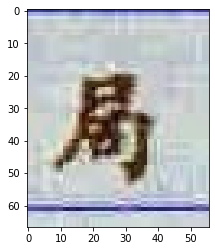

Resnet ('局', 0.9956071972846985)   gridmask ('隆', 0.9878189563751221)   efficientnet ('盈', 0.6410219669342041)  affine ('來', 0.756293535232544)  Ensemble ('局', 0.31667987498267536)
Loading image  1621936985_img.jpg


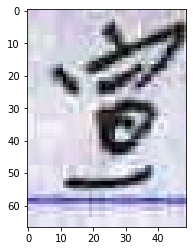

Resnet ('宣', 0.9894024133682251)   gridmask ('社', 0.996813952922821)   efficientnet ('宣', 0.9999376535415649)  affine ('社', 0.9994651675224304)  Ensemble ('社', 0.49906978019018483)
Loading image  1621936987_img.jpg


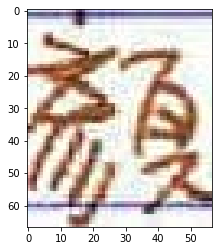

Resnet ('顏', 0.9537337422370911)   gridmask ('政', 0.695906400680542)   efficientnet ('顏', 0.9563876390457153)  affine ('政', 0.9051966667175293)  Ensemble ('顏', 0.4775304923827113)
Loading image  1621936989_img.jpg


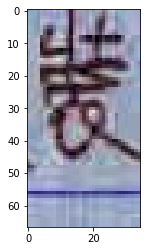

Resnet ('裝', 0.9776010513305664)   gridmask ('澄', 0.8499315977096558)   efficientnet ('裝', 0.771156907081604)  affine ('育', 0.4458501935005188)  Ensemble ('裝', 0.4371895281027296)
Loading image  1621936990_img.jpg


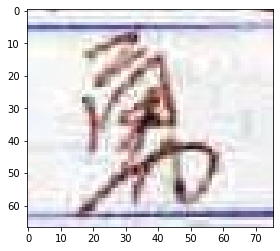

Resnet ('寓', 0.9594835042953491)   gridmask ('基', 0.7043236494064331)   efficientnet ('惠', 0.6146556735038757)  affine ('樂', 0.6896694898605347)  Ensemble ('寓', 0.296463952537124)
Loading image  1621936992_img.jpg


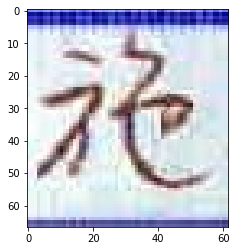

Resnet ('施', 0.9820807576179504)   gridmask ('遠', 0.9826692342758179)   efficientnet ('施', 0.9996143579483032)  affine ('生', 0.5050411820411682)  Ensemble ('施', 0.49542379716560025)
Loading image  1621936994_img.jpg


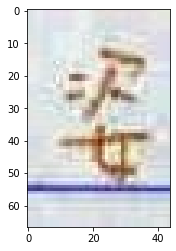

Resnet ('姿', 0.9884902238845825)   gridmask ('雨', 0.898489773273468)   efficientnet ('姿', 0.6767561435699463)  affine ('若', 0.7679504752159119)  Ensemble ('姿', 0.41632881063975447)
Loading image  1621936997_img.jpg


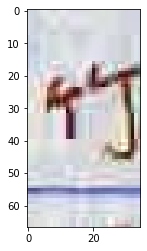

Resnet ('竹', 0.9989515542984009)   gridmask ('私', 0.9379889965057373)   efficientnet ('竹', 0.9130722880363464)  affine ('私', 0.4897042214870453)  Ensemble ('竹', 0.478054971088568)
Loading image  1621937006_img.jpg


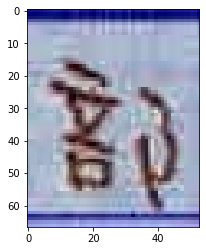

Resnet ('部', 0.9911256432533264)   gridmask ('詠', 0.6495251655578613)   efficientnet ('孟', 0.36427953839302063)  affine ('綸', 0.1502925008535385)  Ensemble ('部', 0.24884365899197292)
Loading image  1621937015_img.jpg


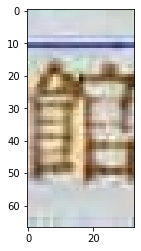

Resnet ('館', 0.9931190013885498)   gridmask ('區', 0.6914121508598328)   efficientnet ('館', 0.8187745213508606)  affine ('娟', 0.43155866861343384)  Ensemble ('館', 0.45297419527837945)
Loading image  1621937018_img.jpg


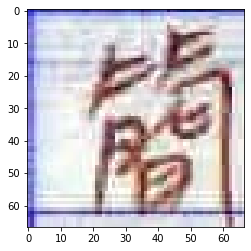

Resnet ('簡', 0.9999998807907104)   gridmask ('研', 0.9990764856338501)   efficientnet ('簡', 0.9999428987503052)  affine ('研', 0.9915112853050232)  Ensemble ('簡', 0.49998585338346757)
Loading image  1621937023_img.jpg


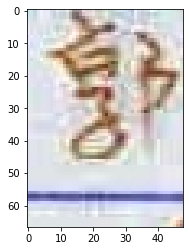

Resnet ('亨', 0.4907686710357666)   gridmask ('念', 0.7658427357673645)   efficientnet ('郭', 0.7228420376777649)  affine ('念', 0.9509856104850769)  Ensemble ('念', 0.429207277473016)
Loading image  1621937025_img.jpg


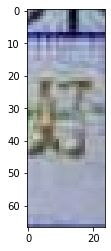

Resnet ('好', 0.9152979850769043)   gridmask ('良', 0.5135287642478943)   efficientnet ('精', 0.1707492470741272)  affine ('秦', 0.28710898756980896)  Ensemble ('好', 0.23014817844159552)
Loading image  1621937026_img.jpg


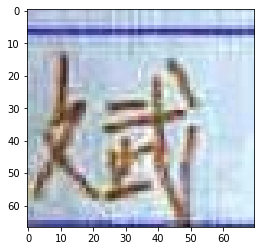

Resnet ('織', 0.6904153227806091)   gridmask ('影', 0.9834250807762146)   efficientnet ('斌', 0.7554046511650085)  affine ('影', 0.7217815518379211)  Ensemble ('影', 0.4263026135752666)
Loading image  1621937027_img.jpg


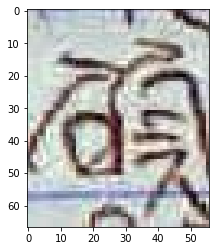

Resnet ('碩', 0.9418585896492004)   gridmask ('環', 0.989518940448761)   efficientnet ('碩', 0.9022408723831177)  affine ('環', 0.9843621253967285)  Ensemble ('環', 0.4934718551359749)
Loading image  1621937028_img.jpg


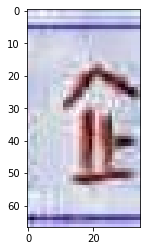

Resnet ('企', 0.8985109925270081)   gridmask ('廣', 0.9996336698532104)   efficientnet ('企', 0.8537273406982422)  affine ('廣', 0.9790888428688049)  Ensemble ('廣', 0.4946812309064228)
Loading image  1621937031_img.jpg


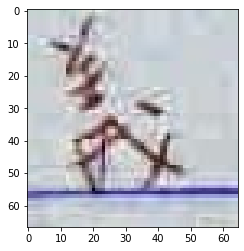

Resnet ('義', 0.7401572465896606)   gridmask ('順', 0.7810354232788086)   efficientnet ('義', 0.55654376745224)  affine ('順', 0.5368338227272034)  Ensemble ('順', 0.32946774205647134)
Loading image  1621937032_img.jpg


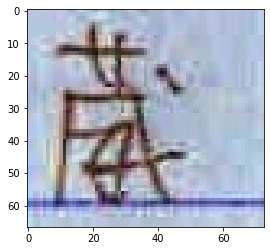

Resnet ('葳', 0.8416464924812317)   gridmask ('造', 0.9913104772567749)   efficientnet ('葳', 0.9995632767677307)  affine ('造', 0.35340479016304016)  Ensemble ('葳', 0.46030258789252443)
Loading image  1621937035_img.jpg


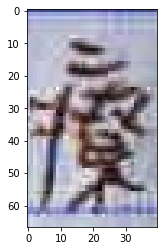

Resnet ('療', 0.9768209457397461)   gridmask ('白', 0.9928412437438965)   efficientnet ('療', 0.9960267543792725)  affine ('白', 0.9922188520431519)  Ensemble ('白', 0.49626502397814337)
Loading image  1621937038_img.jpg


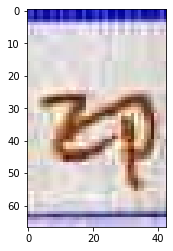

Resnet ('印', 0.8808102607727051)   gridmask ('加', 0.8953036069869995)   efficientnet ('包', 0.5952943563461304)  affine ('視', 0.4685089588165283)  Ensemble ('加', 0.2856134866585762)
Loading image  1621937041_img.jpg


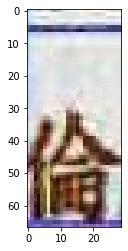

Resnet ('倫', 0.6468473672866821)   gridmask ('壽', 0.6694679856300354)   efficientnet ('益', 0.858163058757782)  affine ('冠', 0.559980034828186)  Ensemble ('益', 0.2150058819854621)
Loading image  1621937045_img.jpg


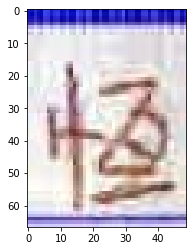

Resnet ('恆', 0.9995772242546082)   gridmask ('王', 0.9891564846038818)   efficientnet ('恆', 0.9999425411224365)  affine ('王', 0.9862668514251709)  Ensemble ('恆', 0.49988002414895405)
Loading image  1621937049_img.jpg


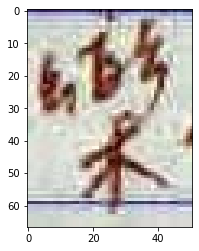

Resnet ('樂', 0.9968679547309875)   gridmask ('廷', 0.9926732182502747)   efficientnet ('樂', 0.9829209446907043)  affine ('廷', 0.8076333999633789)  Ensemble ('樂', 0.49494746920956345)
Loading image  1621937053_img.jpg


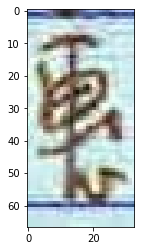

Resnet ('惠', 0.4630573093891144)   gridmask ('樂', 0.9225648045539856)   efficientnet ('惠', 0.8917587995529175)  affine ('樂', 0.1653035581111908)  Ensemble ('惠', 0.33870532869840986)
Loading image  1621937058_img.jpg


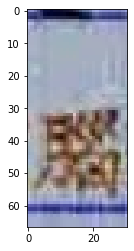

Resnet ('腦', 0.9362804293632507)   gridmask ('詠', 0.16164985299110413)   efficientnet ('盛', 0.6200885772705078)  affine ('昇', 0.29815441370010376)  Ensemble ('腦', 0.23525562968779923)
Loading image  1621937064_img.jpg


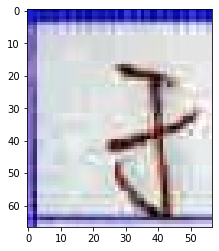

Resnet ('于', 0.7202647924423218)   gridmask ('羽', 0.638235330581665)   efficientnet ('于', 0.9078364968299866)  affine ('羽', 0.5553678870201111)  Ensemble ('于', 0.4070256481328869)
Loading image  1621937157_img.jpg


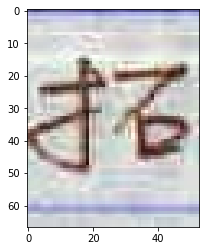

Resnet ('拓', 0.9984816908836365)   gridmask ('茶', 0.9985300302505493)   efficientnet ('拓', 0.9999339580535889)  affine ('茶', 0.9410971999168396)  Ensemble ('拓', 0.4996039829842598)
Loading image  1621937167_img.jpg


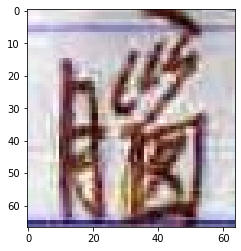

Resnet ('腦', 0.6604188680648804)   gridmask ('迅', 0.7939821481704712)   efficientnet ('腦', 0.801904559135437)  affine ('迅', 0.9446475505828857)  Ensemble ('迅', 0.43465766775142356)
Loading image  1621937179_img.jpg


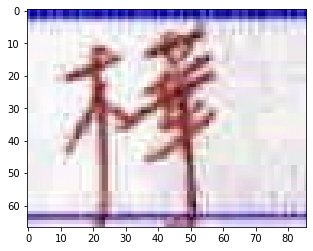

Resnet ('樺', 0.9965865612030029)   gridmask ('瑜', 0.881098747253418)   efficientnet ('樺', 0.9752919673919678)  affine ('優', 0.7405705451965332)  Ensemble ('樺', 0.4929696497484217)
Loading image  1621937252_img.jpg


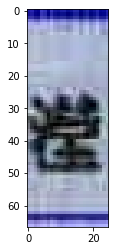

Resnet ('煌', 0.19714680314064026)   gridmask ('孫', 0.14416949450969696)   efficientnet ('善', 0.28895771503448486)  affine ('桂', 0.2744402587413788)  Ensemble ('孫', 0.0937232077980874)
Loading image  1621937275_img.jpg


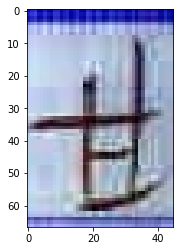

Resnet ('杜', 0.6524525284767151)   gridmask ('車', 0.5278371572494507)   efficientnet ('生', 0.5801975131034851)  affine ('憶', 0.3641938269138336)  Ensemble ('杜', 0.16312792710110102)
Loading image  1622006394_img.jpg


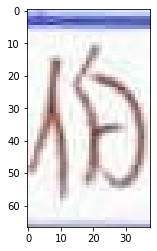

Resnet ('伯', 0.47866833209991455)   gridmask ('化', 0.7774662375450134)   efficientnet ('伯', 0.6962798237800598)  affine ('徐', 0.6574498414993286)  Ensemble ('伯', 0.29373804774246537)


In [5]:
def predict_img(img, model, preprocess_func, mapping):
    img = preprocess_func(img).to(device)
    img = torch.unsqueeze(img, dim=0)
    with torch.no_grad():
        out = model(img)
        out = softmax(out)
        pred_matrix = defaultdict()
        for idx, val in enumerate(out[0]):
            pred_matrix[mapping[idx]] = val.item()

    pred_matrix = {word: pred_matrix[word] for word in  sorted(pred_matrix.keys())}
    return pred_matrix
#         val, pred = torch.max(out, 1)
#         pred = mapping[int(pred.item())]
#     return pred, val

def find_max_prob_word(pred_list):
    pred_word, pred_val = None, -1
    pred_cnt = len(pred_list)
    words = pred_list[0].keys()
    for word in words:
        val = 0
        for pred in pred_list:
            val += pred[word]
        if val > pred_val:
            pred_word = word
            pred_val = val
    
    return pred_word, pred_val / pred_cnt
        
path = './non_repeat/image'
img_paths = sorted(glob(os.path.join(path, '*.jpg')))

for img_path in img_paths:
    if int(img_path.split('/')[-1].split('_')[0]) < 1621936977: continue
    img = cv2.imread(img_path, 1)
    assert(img is not None)
    print('Loading image ', img_path.split('/')[-1])
    ans1 = predict_img(img, model1, preprocess_img, label2word)
    ans2 = predict_img(img, model2, preprocess3_img, label2word2)
    ans3 = predict_img(img, model3, preprocess3_img, label2word2)
    ans4 = predict_img(img, model4, preprocess3_img, label2word2)
    
    pred1 = find_max_prob_word([ans1])
    pred2 = find_max_prob_word([ans2])
    pred3 = find_max_prob_word([ans3])
    pred4 = find_max_prob_word([ans4])
    pred5 = find_max_prob_word([ans1, ans2, ans3, ans4])
    
    plt.imshow(img)
    plt.show()
    print('Resnet {}\t gridmask {}\t efficientnet {}\taffine {}\tEnsemble {}\n'.format(pred1, pred2, pred3, pred4, pred5))
#     input()